In [2]:
from IPython.display import Image

## 8-5. RNN 언어모델 Recurrent Neural Network Language Model, RNNLM)

(n-gram 언어 모델과 NNLM)
- 고정된 개수의 단어만을 입력으로 받아야한다는 단점이 있었음

(RNN)
- 시점(time step)이라는 개념이 도입된 언어 모델
- 입력의 길이를 고정하지 않을 수 있음
- RNN으로 만든 언어 모델을 RNNLM(Recurrent Neural Network Language Model)이라고 함

언어 모델은 주어진 단어 시퀀스로부터 다음 단어를 예측하는 모델

코퍼스 예문: 'what will the fat cat sit on'

↓ RNNLM은 기본적으로 예측 과정에서 이전 시점의 출력을 현재 시점의 입력으로 함

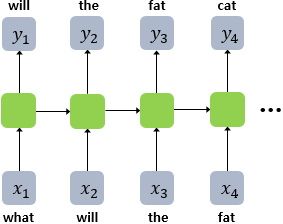

In [3]:
Image('Data/230630/1.png')

will, the, fat, cat, sit, on은 각 시점의 레이블임 

what >>> will

what will >>>> the

what will the >>> fat

what will the fat >>> cat

what will the fat cat >>> sit

what will the fat cat sit 입력 >>> will the fat cat sit on을 예측하도록 훈련됨

#### :: 교사 강요(teacher forcing)
- 테스트 과정에서 t 시점의 출력(→실제 알고 있는 정답)이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법

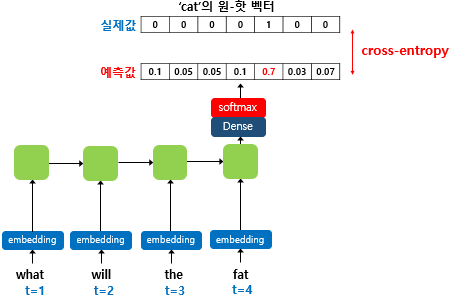

In [4]:
Image('Data/230630/2.png')

훈련 과정 동안 출력층에서 사용하는 활성화 함수는 소프트맥스 함수

모델이 예측한 값과 실제 레이블과의 오차를 계산하기 위해서 손실 함수로 크로스 엔트로피 함수를 사용

#### RNNLM의 구조

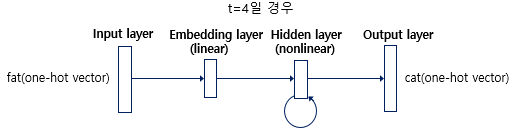

In [5]:
Image('Data/230630/3.png')

- 총 4개의 층(layer)으로 이루어진 인공 신경망
- 입력층(input layer)
    - RNNLM의 현 시점(timestep)은 4로 가정
    - 4번째 입력 단어인 fat의 원-핫 벡터가 입력됨

- 임베딩층(embedding layer) = 투사층(projection layer)
    - 단어 집합의 크기가 V일 때, 임베딩 벡터의 크기를 M으로 설정하면, 
    <br> 각 입력 단어들은 임베딩층에서 V × M 크기의 임베딩 행렬과 곱해짐
    <br> V는 단어 집합의 크기
    - 만약 원-핫 벡터의 차원이 7이고, M이 5라면 임베딩 행렬은 7 × 5 행렬이 됨
    <br> 이 임베딩 행렬은 역전파 과정에서 다른 가중치들과 함께 학습됨
    <br>$$e_t = lookup(x_t)$$
- 은닉층
$$ h_t = tanh(W_xe_t + W_hh_{t-1} + b) $$

- 출력층(output layer)
    - 모델이 예측해야하는 정답에 해당되는 단어 cat의 원-핫 벡터는 출력층에서 모델이 예측한 값의 오차를 구하기 위해 사용될 예정
    - 이 오차로부터 손실 함수를 사용해 인공 신경망이 학습
    - softmax함수를 거치며 (0~1) 사이 실수값을 갖게 됨
$$ \hat{y_t} = softmax(W_yh_t + b)$$
    - $ \hat{y_t} $의 $j$번째 인덱스가 가진 값은, $j$번째 단어가 다음 단어일 확률을 나타냄
    - $ \hat{y_t} $은 실제값에 해당되는 원핫벡터의 값에 가까워져야 함
    - 이를 위해 손실함수로 cross-entropy함수를 사용
    
- 결국 가중치 행렬은 $E, W_x, W_h, W_y$ 4개임

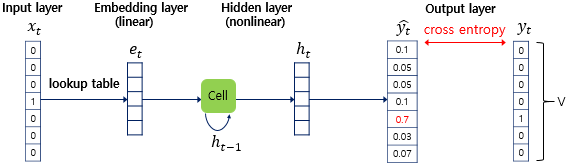

In [6]:
Image('Data/230630/4.png')

## 8-6. RNN을 이용한 텍스트 생성 Text Generation using RNN

- many-to-one 구조의 RNN 사용, 문맥을 반영해 텍스트를 생성하는 모델 만들기
- 예) '경마장에 있는 말이 뛰고 있다'
<br> '그의 말이 법이다'
<br> '가는 말이 고와야 오는 말이 곱다'

In [7]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

text = """경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

In [8]:
# 단어집합 생성하고 크기 확인하기
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index) + 1
# 단어집합 저장할 때는 Keras 토크나이저 정수 인코딩이 1부터 시작, 패딩을 위한 0을 고려하여 +1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 12


In [9]:
tokenizer.word_index

{'말이': 1,
 '경마장에': 2,
 '있는': 3,
 '뛰고': 4,
 '있다': 5,
 '그의': 6,
 '법이다': 7,
 '가는': 8,
 '고와야': 9,
 '오는': 10,
 '곱다': 11}

In [13]:
text.split('\n')

['경마장에 있는 말이 뛰고 있다', '', '그의 말이 법이다', '', '가는 말이 고와야 오는 말이 곱다', '']

In [17]:
tokenizer.texts_to_sequences([text.split('\n')[0]])

[[2, 3, 1, 4, 5]]

In [19]:
tokenizer.texts_to_sequences([text.split('\n')[2]])

[[6, 1, 7]]

In [20]:
tokenizer.texts_to_sequences([text.split('\n')[4]])

[[8, 1, 9, 10, 1, 11]]

In [21]:
sequences = list()
for line in text.split('\n'): # 줄바꿈 문자를 기준으로 문장 토큰화
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

print('학습에 사용할 샘플의 개수: %d' % len(sequences))

학습에 사용할 샘플의 개수: 11


In [22]:
sequences

[[2, 3],
 [2, 3, 1],
 [2, 3, 1, 4],
 [2, 3, 1, 4, 5],
 [6, 1],
 [6, 1, 7],
 [8, 1],
 [8, 1, 9],
 [8, 1, 9, 10],
 [8, 1, 9, 10, 1],
 [8, 1, 9, 10, 1, 11]]

↑ 위의 데이터는 아직 레이블로 사용될 단어를 분리하지 않은 훈련 데이터

[2, 3]은 [경마장에, 있는]에 해당되며 [2, 3, 1]은 [경마장에, 있는, 말이]에 해당

전체 훈련 데이터에 대해서 맨 우측에 있는 단어에 대해서만 레이블로 분리해야 함

우선 전체 샘플에 대해서 길이를 일치시켜 줍니다. 가장 긴 샘플의 길이를 기준으로 함

In [23]:
max_len = max(len(l) for l in sequences) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 6


pad_sequences()는 모든 샘플에 대해서 0을 사용하여 길이를 맞춰줌 (maxlen을 최대 길이로 패딩)

In [24]:
# 전체 샘플의 길이를 max_len = 6으로 패딩
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')

In [25]:
sequences

array([[ 0,  0,  0,  0,  2,  3],
       [ 0,  0,  0,  2,  3,  1],
       [ 0,  0,  2,  3,  1,  4],
       [ 0,  2,  3,  1,  4,  5],
       [ 0,  0,  0,  0,  6,  1],
       [ 0,  0,  0,  6,  1,  7],
       [ 0,  0,  0,  0,  8,  1],
       [ 0,  0,  0,  8,  1,  9],
       [ 0,  0,  8,  1,  9, 10],
       [ 0,  8,  1,  9, 10,  1],
       [ 8,  1,  9, 10,  1, 11]])

이제 각 샘플의 마지막 단어를 레이블로 분리

In [27]:
sequences = np.array(sequences)
x = sequences[:,:-1]
y = sequences[:,-1]

In [28]:
x

array([[ 0,  0,  0,  0,  2],
       [ 0,  0,  0,  2,  3],
       [ 0,  0,  2,  3,  1],
       [ 0,  2,  3,  1,  4],
       [ 0,  0,  0,  0,  6],
       [ 0,  0,  0,  6,  1],
       [ 0,  0,  0,  0,  8],
       [ 0,  0,  0,  8,  1],
       [ 0,  0,  8,  1,  9],
       [ 0,  8,  1,  9, 10],
       [ 8,  1,  9, 10,  1]])

In [29]:
y

array([ 3,  1,  4,  5,  1,  7,  1,  9, 10,  1, 11])

RNN 모델에 훈련 데이터를 훈련 시키기 전에 레이블에 대해서 원-핫 인코딩을 수행

In [31]:
y = to_categorical(y, num_classes=vocab_size)

In [33]:
y

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

#### 모델 설계하기: RNN모델에 데이터 훈련시킴

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

embedding_dim = 10
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
1/1 - 1s - loss: 2.4600 - accuracy: 0.2727 - 901ms/epoch - 901ms/step
Epoch 2/200
1/1 - 0s - loss: 2.4448 - accuracy: 0.4545 - 4ms/epoch - 4ms/step
Epoch 3/200
1/1 - 0s - loss: 2.4293 - accuracy: 0.5455 - 4ms/epoch - 4ms/step
Epoch 4/200
1/1 - 0s - loss: 2.4136 - accuracy: 0.5455 - 4ms/epoch - 4ms/step
Epoch 5/200
1/1 - 0s - loss: 2.3975 - accuracy: 0.5455 - 5ms/epoch - 5ms/step
Epoch 6/200
1/1 - 0s - loss: 2.3810 - accuracy: 0.5455 - 4ms/epoch - 4ms/step
Epoch 7/200
1/1 - 0s - loss: 2.3638 - accuracy: 0.5455 - 3ms/epoch - 3ms/step
Epoch 8/200
1/1 - 0s - loss: 2.3459 - accuracy: 0.3636 - 4ms/epoch - 4ms/step
Epoch 9/200
1/1 - 0s - loss: 2.3273 - accuracy: 0.3636 - 3ms/epoch - 3ms/step
Epoch 10/200
1/1 - 0s - loss: 2.3077 - accuracy: 0.3636 - 3ms/epoch - 3ms/step
Epoch 11/200
1/1 - 0s - loss: 2.2872 - accuracy: 0.3636 - 4ms/epoch - 4ms/step
Epoch 12/200
1/1 - 0s - loss: 2.2656 - accuracy: 0.3636 - 4ms/epoch - 4ms/step
Epoch 13/200
1/1 - 0s - loss: 2.2430 - accuracy: 0.3636 -

임베딩 벡터의 차원은 10, 은닉 상태의 크기는 32

다 대 일 구조의 RNN을 사용

전결합층(Fully Connected Layer)을 출력층으로 단어 집합 크기만큼의 뉴런을 배치하여 모델을 설계

마지막 시점에서 모든 가능한 단어 중 하나의 단어를 예측하는 다중 클래스 분류 문제를 수행하는 모델임 (손실함수: crossentropy, 출력층 활성화함수: softmax)

In [34]:
# 모델이 정확하게 예측하고 있는지 문장을 생성하는 함수를 만들어서 출력

def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        # 현재 단어에 대한 정수 인코딩과 패딩
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=5, padding='pre')
        # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면 break
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [36]:
print(sentence_generation(model, tokenizer, '경마장에', 4))

경마장에 있는 말이 뛰고 있다


In [37]:
print(sentence_generation(model, tokenizer, '그의', 2))

그의 말이 법이다


In [38]:
print(sentence_generation(model, tokenizer, '가는', 5))


가는 말이 고와야 오는 말이 곱다


앞의 문맥을 기준으로 '말이' 라는 단어 다음에 나올 단어를 기존의 훈련 데이터와 일치하게 예측함

이 모델은 충분한 훈련 데이터를 갖고 있지 못하므로 위에서 문장의 길이에 맞게 적절하게 예측해야하는 횟수 4, 2, 5를 각각 인자값으로 주었음

이 이상의 숫자를 주면 기계는 '있다', '법이다', '곱다' 다음에 나오는 단어가 무엇인지 배운 적이 없으므로 임의 예측을 함

#### 아래부터는 더 많은 훈련 데이터를 가지고 실습

### LSTM 이용해 텍스트 생성

뉴욕 타임즈 기사의 제목데이터

https://www.kaggle.com/aashita/nyt-comments ArticlesApril2018.csv 데이터를 다운로드

In [39]:
import pandas as pd
import numpy as np
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [40]:
df = pd.read_csv('Data/230630/ArticlesApril2018.csv')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [41]:
print('열의 개수: ',len(df.columns))
print(df.columns)

열의 개수:  15
Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


In [42]:
# headline 열 Null 값이 있는지 확인
df['headline'].isnull().values.any()

False

In [43]:
# headline 열에서 모든 신문 기사의 제목을 뽑아서 하나의 리스트로 저장
headline = []
# 헤드라인의 값들을 리스트로 저장
headline.extend(list(df.headline.values)) 
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

#### Unknwon이 있으므로, 노이즈 데이터 제거

In [44]:
print('총 샘플의 개수 : {}'.format(len(headline)))
headline = [word for word in headline if word != "Unknown"]
print('노이즈값 제거 후 샘플의 개수 : {}'.format(len(headline)))

총 샘플의 개수 : 1324
노이즈값 제거 후 샘플의 개수 : 1214


In [45]:
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

#### 구두점 제거와 단어 소문자화

In [46]:
def repreprocessing(raw_sentence):
    preprocessed_sentence = raw_sentence.encode("utf8").decode("ascii",'ignore')
    # 구두점 제거와 동시에 소문자화
    return ''.join(word for word in preprocessed_sentence if word not in punctuation).lower()

preprocessed_headline = [repreprocessing(x) for x in headline]
preprocessed_headline[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

#### 단어 집합(vocabulary)을 만들고 크기를 확인

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_headline)
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 3494


#### 훈련데이터 구성

In [48]:
sequences = list()

for sentence in preprocessed_headline:

    # 각 샘플에 대한 정수 인코딩
    encoded = tokenizer.texts_to_sequences([sentence])[0] 
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

#### index_to_word 어떤 정수가 어떤 단어를 의미하는지 알아봄

In [49]:
index_to_word = {}
for key, value in tokenizer.word_index.items(): # 인덱스를 단어로 바꾸기 위해 index_to_word를 생성
    index_to_word[value] = key

print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


#### 데이터를 분리하기 전에 전체 샘플의 길이를 동일하게 만드는 패딩 작업

In [50]:
# 패딩 작업을 수행하기 전에 가장 긴 샘플의 길이를 확인

max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 24


In [51]:
# 가장 긴 샘플의 길이인 24로 모든 샘플의 길이를 패딩
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]]


In [53]:
# 맨 우측 단어만 레이블로 분리
sequences = np.array(sequences)
x = sequences[:,:-1]
y = sequences[:,-1]

In [54]:
x[:3]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  99],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  99, 269],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,  99, 269, 371]])

In [55]:
y[:3]

array([ 269,  371, 1115])

In [56]:
# 레이블 데이터 y에 대한 원-핫인코딩 수행
y = to_categorical(y, num_classes=vocab_size)

#### 모델 설계

임베딩 벡터의 차원은 10, 은닉 상태의 크기는 128

다 대 일 구조의 LSTM 사용 (다중 클래스 분류 문제)
- 출력층에 소프트맥스 함수
- 손실함수 크로스 엔트로피 함수

전결합층(Fully Connected Layer)을 출력층으로 단어 집합 크기만큼의 뉴런을 배치

200 에포크 수행

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

embedding_dim = 10
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
244/244 - 5s - loss: 7.6518 - accuracy: 0.0278 - 5s/epoch - 21ms/step
Epoch 2/200
244/244 - 3s - loss: 7.1183 - accuracy: 0.0291 - 3s/epoch - 14ms/step
Epoch 3/200
244/244 - 3s - loss: 6.9824 - accuracy: 0.0340 - 3s/epoch - 14ms/step
Epoch 4/200
244/244 - 4s - loss: 6.8589 - accuracy: 0.0395 - 4s/epoch - 14ms/step
Epoch 5/200
244/244 - 3s - loss: 6.7113 - accuracy: 0.0450 - 3s/epoch - 14ms/step
Epoch 6/200
244/244 - 3s - loss: 6.5402 - accuracy: 0.0493 - 3s/epoch - 14ms/step
Epoch 7/200
244/244 - 3s - loss: 6.3458 - accuracy: 0.0541 - 3s/epoch - 14ms/step
Epoch 8/200
244/244 - 4s - loss: 6.1461 - accuracy: 0.0593 - 4s/epoch - 14ms/step
Epoch 9/200
244/244 - 4s - loss: 5.9500 - accuracy: 0.0620 - 4s/epoch - 14ms/step
Epoch 10/200
244/244 - 3s - loss: 5.7659 - accuracy: 0.0654 - 3s/epoch - 14ms/step
Epoch 11/200
244/244 - 4s - loss: 5.5904 - accuracy: 0.0714 - 4s/epoch - 14ms/step
Epoch 12/200
244/244 - 3s - loss: 5.4268 - accuracy: 0.0757 - 3s/epoch - 14ms/step
Epoch 13/200


#### 문장을 생성하는 함수 sentence_generation로 (상단에 정의) 문장을 생성

In [58]:
# 임의의 단어 'i'에 대해서 10개의 단어를 추가 생성
print(sentence_generation(model, tokenizer, 'i', 10))

i judgment first be student window office golden muellers recap very


In [59]:
# 임의의 단어 'how'에 대해서 10개의 단어를 추가 생성
print(sentence_generation(model, tokenizer, 'how', 10))

how to judgment is us new match hero hero outside office


## 8-7 문자단위 RNN